# Landmark Matching in Images

DELF (DEep Local Features) is a DL model that achieves state of the art image retrieval results. It can take an image, search it against a database of pre-processed images, and find corresponding matches.

It works by extracting key points in an image and descriptions for those key points. At retrieval time, it'll find images with similar descriptions, and matches their key points geometrically to verify if the image is a proper match. The descriptions in this case is a length 40 vector.

## Prediction Examples:

Match Example | Non-Match Example
- | -
![prediction example](https://github.com/tensorflow/models/raw/master/research/delf/delf/python/examples/matched_images_example.png) | ![prediction example](https://i.imgur.com/FMi3uFZ.png)

## How Good Is This Model?

This model achieves state of the art results as of the paper's publishing in 2016. This model has been specifically trained on landmarks ([Google-Landmarks](https://research.googleblog.com/2018/03/google-landmarks-new-dataset-and.html))


This notebook is largely derived from the [original DELF Notebook](https://github.com/tensorflow/hub/blob/master/examples/colab/tf_hub_delf_module.ipynb) in tensorflow/hub. See below for the original license notice.

## Upgrade TF Dependencies And Import Python Modules

This model uses Tensorflow Modules, which requires Tensorflow version >= 1.7 and TF-HUB >= 0.1. Running the below code cell will automatically install these dependencies.

In [0]:
# Update the versions of TF and TF-Hub, if needed.

import pkg_resources

tf_req = pkg_resources.Requirement('tensorflow>=1.7.0rc0')
if not any(p in tf_req for p in pkg_resources.Environment()['tensorflow']):
  print('Installing TF')
  !pip install -q 'tensorflow>=1.7.0rc0'

tf_hub_req = pkg_resources.Requirement('tensorflow-hub>=0.1.0')
if not any(p in tf_hub_req for p in pkg_resources.Environment()['tensorflow-hub']):
  print('Installing TF-Hub')
  !pip install -q 'tensorflow-hub>=0.1.0'

In [0]:
# Import our Dependencies

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from StringIO import StringIO
import tensorflow as tf
import tensorflow_hub as hub
from urllib2 import urlopen

W0611 02:41:43.894212 139667004385152 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


## Download DELF Tensorflow Module from ModelDepot

In [0]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://modeldepot.io/mikeshi/delf')

## Define and Fetch Images for Inference

In the next cell, we specify the URLs of two images we would like to process with DELF in order to match and compare them.

In [0]:
# images from Landmark Dataset v2.

IMAGE_1_URL = 'http://upload.wikimedia.org/wikipedia/commons/d/da/Liberty_Island2.JPG'
IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/b/b2/Liberty_Statue_%2816841011%29.jpeg'

In [0]:
# The names that will be used for the resized local images.

IMAGE_1_JPG = 'image_1.jpg'
IMAGE_2_JPG = 'image_2.jpg'

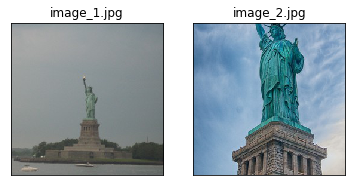

In [0]:
#The images that will be processed by DELF
def download_and_resize_image(url, filename, new_width=256, new_height=256):
  response = urlopen(url)
  image_data = response.read()
  pil_image = Image.open(StringIO(image_data))
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert('RGB')
  pil_image_rgb.save(filename, format='JPEG', quality=90)

download_and_resize_image(IMAGE_1_URL, IMAGE_1_JPG)
download_and_resize_image(IMAGE_2_URL, IMAGE_2_JPG)

def show_images(image_path_list):
  plt.figure()
  for i, image_path in enumerate(image_path_list):
    plt.subplot(1, len(image_path_list), i+1)
    plt.imshow(np.asarray(Image.open(image_path)))
    plt.title(image_path)
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
  plt.show()

show_images([IMAGE_1_JPG, IMAGE_2_JPG])

Next, we define a function to read the images into a tensor so that they can be processed by TensorFlow.

In [0]:
def image_input_fn():
  filename_queue = tf.train.string_input_producer(
      [IMAGE_1_JPG, IMAGE_2_JPG], shuffle=False)
  reader = tf.WholeFileReader()
  _, value = reader.read(filename_queue)
  image_tf = tf.image.decode_jpeg(value, channels=3)
  return tf.image.convert_image_dtype(image_tf, tf.float32)

## Apply the DELF module to the data

The DELF module takes an image as input and will describe noteworthy points with vectors.

In [0]:
# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = m(module_inputs, as_dict=True)

image_tf = image_input_fn()

with tf.train.MonitoredSession() as sess:
  results_dict = {}  # Stores the locations and their descriptors for each image
  for image_path in [IMAGE_1_JPG, IMAGE_2_JPG]:
    image = sess.run(image_tf)
    print('Extracting locations and descriptors from %s' % image_path)
    results_dict[image_path] = sess.run(
        [module_outputs['locations'], module_outputs['descriptors']],
        feed_dict={image_placeholder: image})

Extracting locations and descriptors from image_1.jpg
Extracting locations and descriptors from image_2.jpg


## Use the locations and description vectors to match the images

Loaded image 1's 130 features
Loaded image 2's 214 features
Found 28 inliers


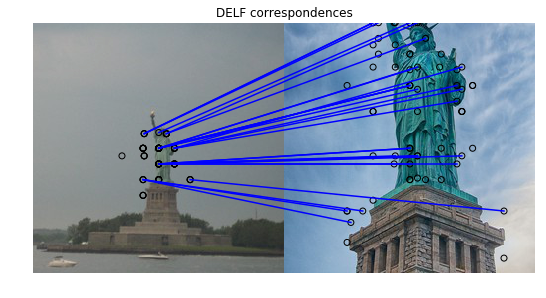

In [0]:
def match_images(results_dict, image_1_path, image_2_path):
  distance_threshold = 0.8

  # Read features.
  locations_1, descriptors_1 = results_dict[image_1_path]
  num_features_1 = locations_1.shape[0]
  print("Loaded image 1's %d features" % num_features_1)
  locations_2, descriptors_2 = results_dict[image_2_path]
  num_features_2 = locations_2.shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(descriptors_1)
  _, indices = d1_tree.query(
      descriptors_2, distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      locations_2[i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      locations_1[indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

  # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots(figsize=(9, 18))
  img_1 = mpimg.imread(image_1_path)
  img_2 = mpimg.imread(image_2_path)
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      img_1,
      img_2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title('DELF correspondences')

match_images(results_dict, IMAGE_1_JPG, IMAGE_2_JPG)


This notebook is derived work from the [original notebook](https://github.com/tensorflow/hub/blob/master/examples/colab/tf_hub_delf_module.ipynb). Below is the original copyright notice distributed with the notebook.

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================